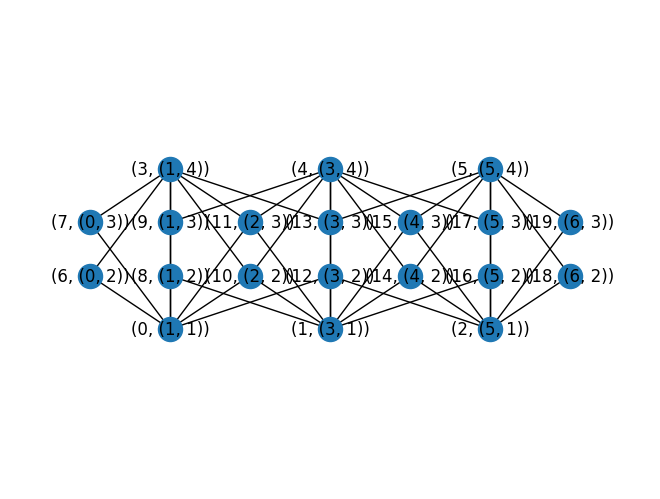

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import csv
G = nx.Graph()

def coord_to_index(coord):
    return coord[0] + coord[1]*size[0]

points1 = [] #placement of lidars for one side
points2 = [] #placement of lidars for other side
points3 = [] #vertices to cover
index = 0

for i in range(1, 6, 2):
    point = (i, 1)
    points1.append((index, point))
    index+=1
for i in range(1, 6, 2):
    point = (i, 4)
    points2.append((index, point))
    index+=1
for i in range(0, 7):
    for j in range(2, 4):
        point = (i, j)
        points3.append((index, point))
        index+=1

G.add_nodes_from(points1 + points2 + points3)


#edge that represents scope between lidar placement and vertices to cover
for node1 in points1:
  for j in range (node1[1][1]+1, node1[1][1]+3):
    if(j==node1[1][1]+1):
      for i in range(node1[1][0]-2, node1[1][0]+3):
        for node3 in points3:
          if (i,j) == node3[1]:
            G.add_edge(node1, node3, index=index)
            index+=1
    if(j== node1[1][1]+2):
      for i in range(node1[1][0]-1, node1[1][0]+2):
        for node3 in points3:
          if (i,j) == node3[1]:
            G.add_edge(node1, node3, index=index)
            index+=1
for node2 in points2:
  for j in range (node2[1][1]-2,node2[1][1]):
    if(j== node2[1][1]-2):
      for i in range(node2[1][0]-1, node2[1][0]+2):
        for node3 in points3:
          if (i,j) == node3[1]:
            G.add_edge(node2, node3, index=index)
            index+=1
    if(j==node2[1][1]-1):
      for i in range(node2[1][0]-2, node2[1][0]+3):
        for node3 in points3:
          if (i,j) == node3[1]:
            G.add_edge(node2, node3, index=index)
            index+=1

pos = {node: node[1] for node in G.nodes()} 
nx.draw(G, pos,with_labels=True)

plt.xlim(-1, 7)
plt.ylim(-2, 7)

plt.xticks(range(0, 7))
plt.yticks(range(1, 7))

plt.show()
pointsL = points1 + points2


In [6]:
n = len(G.nodes) + len(G.edges)

def energyF1(x):
    somme = 0
    somme += sum(x[i[0]] for i in pointsL) #minimize the placement of lidars
    #constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
    for node in points3:
        #degree = len(G.edges(node))
        adjEdges = [G[node2][node]["index"] for node2 in G.neighbors(node)]
        #print(adjEdges)
        #somme += sum((x[i]- x[i]*degree) for i in adjEdges) #want to activate every edge
        somme += sum((-x[i]) for i in adjEdges) + 1
    for node in pointsL:
        somme += sum(x[G[node2][node]["index"]] - x[node[0]] for node2 in G.neighbors(node)) 
    return somme

def energyF2(x):
    somme = 0
    somme += sum(x[i[0]] for i in pointsL) #minimize the placement of lidars
    #constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
    somme += sum(x[node[0]]- x[node[0]]*G.degree[node] for node in points3)
    somme += sum(-1*x[node[0]] +1 for node in points3)
    #Link the relation between edge activation and lidar placement activation
    for node in points3:
        somme += x[node[0]] - sum(x[v[0]] for v in G.neighbors(node))
    return somme

def energyF3(x):
    somme = 0
    somme += sum(x[i[0]] for i in pointsL) #minimize the placement of lidars
    #constraint on number of activate edge
    for node in points3:
        for node2 in G.neighbors(node): 
            somme += 1 - x[G[node2][node]["index"]]
            somme += x[G[node2][node]["index"]] - x[G[node2][node]["index"]]*G.degree[node]
    #constraint link active edge and node
    for node in points3:
        somme += sum(x[G[node2][node]["index"]] for node2 in G.neighbors(node)) - sum(x[v[0]] for v in G.neighbors(node))
        #somme += sum(x[G[node2][node]["index"]] - x[node[0]] for node2 in G.neighbors(node)) 
    return somme


In [7]:
f = lambda x: energyF1(x)

In [8]:
from typing import List, Union, Callable  # for type hints

import numpy as np
import random
from time import time
import math


def sa_solve(
    f: Callable,
    n: int,
    n_iter: int = 1,
    n_temp_iter: int = 20000,
    temp: float = 50,
    warm_start: Union[List, np.ndarray] = None,
) -> (List, List, float):

    samples = []
    energies = []
    indices = list(range(0, n))

    start_time = time()

    for _ in range(n_iter):
        if warm_start is None:
            x = np.array([0] * n)
        else:
            x = np.array(warm_start)
        curr, curr_eval = x, f(x)
        best, best_eval = curr, curr_eval

        for i in range(n_temp_iter):
            candidate = np.copy(curr)
            flip_pos = random.sample(indices, 1)
            candidate[flip_pos] = int(not candidate[flip_pos])
            #print(candidate)
            candidate_eval = f(candidate)
            #print(candidate_eval)
            if candidate_eval <= best_eval:
                best, best_eval = candidate, candidate_eval

            diff = candidate_eval - curr_eval
            t = temp / float(i + 1)

            metropolis_eval = math.exp(-diff / t)

            if diff <= 0 or random.random() < metropolis_eval:
                curr, curr_eval = candidate, candidate_eval

        samples.append(best.tolist())
        energies.append(best_eval)

    runtime = time() - start_time
    
    return samples, energies, runtime

In [9]:
n_temp_iter = 20000
temp = 50
for i in range (1):
    print(samples)
    samples, energies, runtime = sa_solve(f, n)
    S = []
    T = []
    R = []
    for i in range(len(pointsL)):
        if samples[0][i]:
            S.append(pointsL[i])
    # for i in range(len(points3)):
    #     if samples[0][i]:
    #         T.append(points3[i])
    # for i in range(len(G.edges)):
    #     if samples[0][i]:
    #         R.append(G[node2][node]["index"])
    with open('resultSA.csv', 'a') as filecsv:
        writer = csv.writer(filecsv)
        writer.writerow(["energyF1",n_temp_iter, temp] + S)
#print(S)
with open('resultSA.csv', 'r') as csv_file:
       csv_reader = csv.reader(csv_file)
       rows = list(csv_reader)
#print(rows)
pos = {node: node[1] for node in G.nodes()}
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_nodes(G, pos, S, node_color='red')
#nx.draw_networkx_nodes(G, pos, T, node_color='purple')

NameError: name 'samples' is not defined